<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/seattle_bicycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [10]:
# 後からDateがindexで日時だと分かったため、オプションを追加して時系列データとして読み込むように変更
data = pd.read_csv("https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD", index_col="Date", parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [11]:
data.describe()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
count,143608.000000,143608.000000,143608.000000
mean,111.162735,50.547616,60.615119
std,141.443433,65.157096,87.921215
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


In [13]:
data.columns = ['Total', 'East', 'West']
data.dropna().describe()

,Total,East,West
count,143608.000000,143608.000000,143608.000000
mean,111.162735,50.547616,60.615119
std,141.443433,65.157096,87.921215
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


Text(0, 0.5, 'Hourly Bicycle Count')

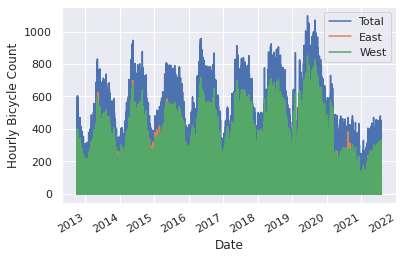

In [14]:
data.plot()
plt.ylabel('Hourly Bicycle Count')

2020年以降はコロナの影響で交通量が激減しているのが分かる

Text(0, 0.5, 'Weekly Bicycle Count')

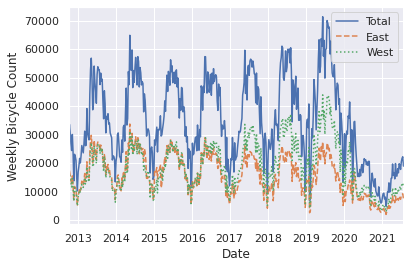

In [15]:
# データの粒度が細かすぎるため、粗い粒度で再サンプリングする
weekly = data.resample('W').sum()
weekly.plot(style=['-', '--', ':'])
plt.ylabel('Weekly Bicycle Count')

Text(0, 0.5, 'Mean Daily Count')

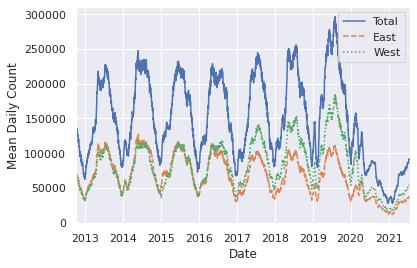

In [16]:
# 30日間の移動平均
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=['-', '--', ':'])
plt.ylabel('Mean Daily Count')

Text(0, 0.5, 'Mean Daily Count by Gaussian')

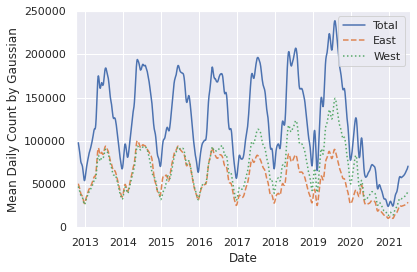

In [17]:
# ガウス窓を適用して滑らかな移動平均を求める
# ガウシアンフィルタをかけるのに必要な標準偏差は、sum(std)として入力する
daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(style=['-', '--', ':'])
plt.ylabel('Mean Daily Count by Gaussian')

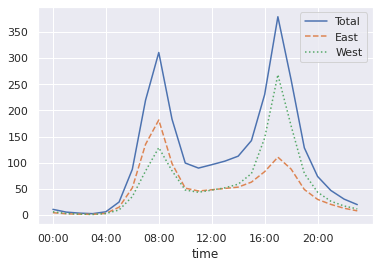

In [19]:
# 次は細かい粒度で解析する
# 時間ごとにgroupbyで集約する
by_time = data.groupby(data.index.time).mean()
# np.arange()は数列を生成する
# hourly_ticksは4時間間隔6要素(1日分)の配列
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'])

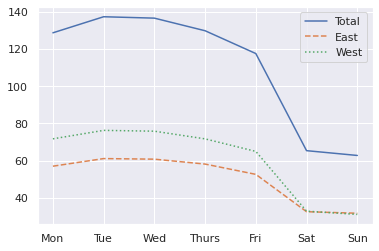

In [20]:
# 曜日ごとに同様の集約を行う
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'])

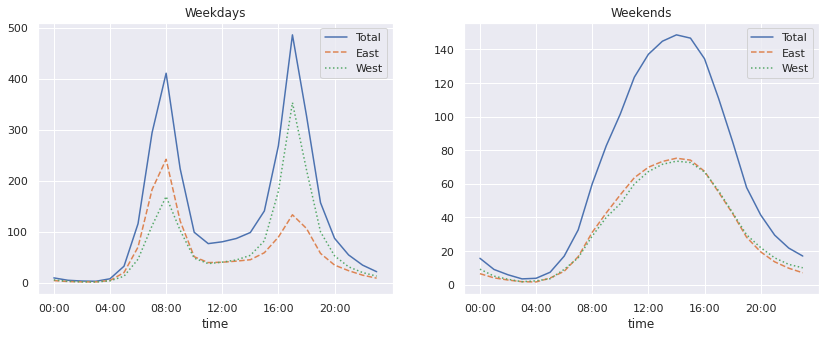

In [22]:
# 平日の交通量が週末の2倍以上であることが分かった
# 次は平日と週末の時間的傾向を可視化する
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=['-', '--', ':'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=['-', '--', ':'])

平日は通勤、帰宅による交通量が多いが、週末はレクリエーションなどのために昼間にかけての交通量の増加が見られる